In [2]:
%matplotlib inline
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

In [4]:
# clear_cache('cython')

In [5]:
defaultclock.dt = 0.01*ms

In [10]:
#### Borrowing from input factory of neurodynex package

def get_step_current(t_start, t_end, t_total, unit_time, amplitude):

    I_arr = np.zeros((t_total,1))*amp
    I_arr[t_start : t_end+1, 0] = amplitude
    t_arr = TimedArray(np.arange(0, t_total), dt = 1*unit_time)
    I_arr = TimedArray(I_arr, dt = 1*unit_time)
    return t_arr, I_arr

In [7]:
ps1 = {
    "CABLE_LENGTH" : 500. * um,  # length of dendrite
    "CABLE_DIAMETER" : 2. * um,  # diameter of dendrite
    "R_LONGITUDINAL" : 0.5 * kohm * mm,  # Intracellular medium resistance
    "R_TRANSVERSAL" : 1.25 * Mohm * mm ** 2,  # cell membrane resistance (->leak current)
    "E_LEAK" : -70. * mV,  # reversal potential of the leak current (-> resting potential)
    "CAPACITANCE" : 0.8 * uF / cm ** 2
}

In [23]:
#### Borrowing from neurodynex package

def passive_cable(I_arr, I_loc, params, duration, initial_voltage, nr_compartments):

    length=params["CABLE_LENGTH"]
    diameter=params["CABLE_DIAMETER"]
    r_longitudinal=params["R_LONGITUDINAL"]
    r_transversal=params["R_TRANSVERSAL"]
    e_leak=params["E_LEAK"]
    capacitance=params["CAPACITANCE"]

    cable_morphology = Cylinder(diameter=diameter, length=length, n=nr_compartments)
    
    EL = e_leak
    RT = r_transversal
    
    eqs = """
    Iext = current(t, location_index): amp (point current)
    location_index : integer (constant)
    Im = (EL-v)/RT : amp/meter**2
    """
    cable_model = SpatialNeuron(morphology=cable_morphology, model=eqs, Cm=capacitance, Ri=r_longitudinal)
    monitor_v = StateMonitor(cable_model, "v", record=True)

    # inject all input currents at the specified location:
    nr_input_locations = len(I_loc)
    input_current_0 = np.insert(I_arr.values, 0, 0., axis=1) * amp  # insert default current: 0. [amp]
    current = TimedArray(input_current_0, dt=I_arr.dt * second)
    for current_index in range(nr_input_locations):
        insert_location = I_loc[current_index]
        compartment_index = int(np.floor(insert_location / (length / nr_compartments)))
        # next line: current_index+1 because 0 is the default current 0Amp
        cable_model.location_index[compartment_index] = current_index + 1

    # set initial values and run for 1 ms
    cable_model.v = initial_voltage

    ce_net = Network(cable_model)
    ce_net.add(monitor_v)
    # hh_net.add(spikemon)
    ce_net.run(duration)


    # run(duration)
    return monitor_v, cable_model

    

In [24]:
t_arr, I_arr = get_step_current(500, 510, 512, unit_time=us, amplitude=3. * namp)
voltage_monitor, cable_model = passive_cable(
    I_arr = I_arr,
    I_loc = [0.1 * mm],
    params = ps1,
    duration = 2 * ms,
    initial_voltage = -60*mV, 
    nr_compartments=100        
)

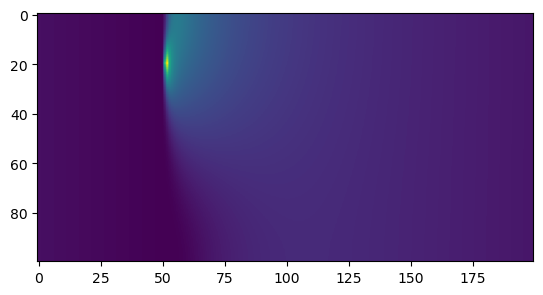

In [25]:
plt.imshow(voltage_monitor.v /volt)

# 4.1. Exercise: spatial and temporal evolution of a pulse input

In [19]:
ps2 = ps1.copy()
ps2['CABLE_LENGTH'] = 0.8 * mmetre
ps2

{'CABLE_LENGTH': 0.8 * mmetre,
 'CABLE_DIAMETER': 2. * umetre,
 'R_LONGITUDINAL': 0.5 * ohm * meter,
 'R_TRANSVERSAL': 1.25 * metre ** 4 * kilogram * second ** -3 * amp ** -2,
 'E_LEAK': -70. * mvolt,
 'CAPACITANCE': 0.008 * farad / (meter ** 2)}

In [26]:
t_arr, I_arr = get_step_current(1000, 1100, 3000, unit_time=us, amplitude=0.8 * namp)
voltage_monitor, cable_model = passive_cable(
    I_arr = I_arr,
    I_loc = [0.2 * mm],
    params = ps2,
    duration = 3 * ms,
    initial_voltage = ps2["E_LEAK"], 
    nr_compartments=200        
)

In [31]:
(voltage_monitor.v/mV).shape

(200, 300)

In [34]:
np.where( voltage_monitor.v/mV == np.max(voltage_monitor.v/mV))

(array([50], dtype=int64), array([111], dtype=int64))

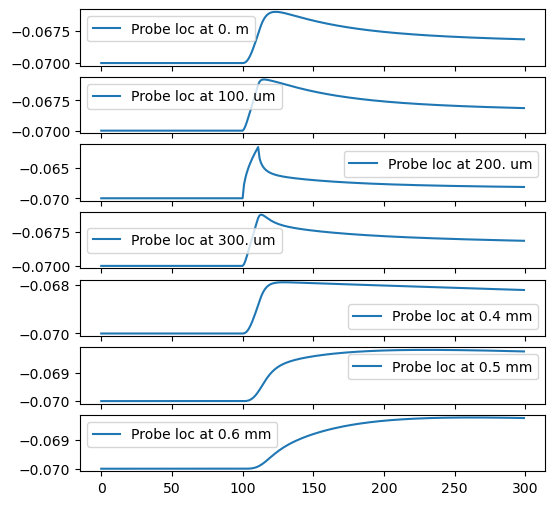

In [46]:
fig,ax = plt.subplots(7,1,figsize=(6,6))

probe_locs = [100*i for i in range(7)] * um 

for i, probe_loc in enumerate(probe_locs):
    v = voltage_monitor[cable_model.morphology[probe_loc]].v
    ax[i].plot(v, label = f"Probe loc at {probe_loc}")
    ax[i].legend();

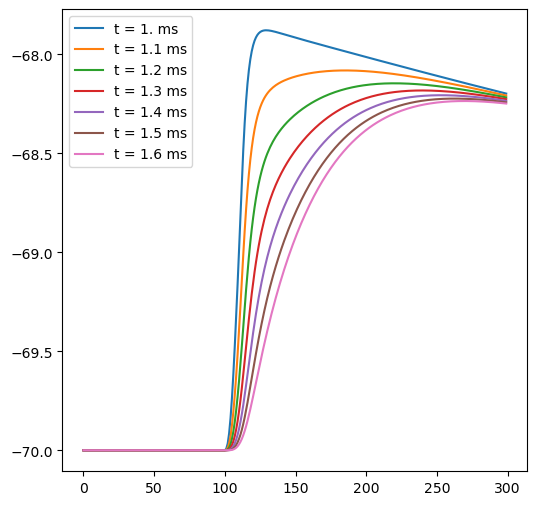

In [66]:
fig,ax = plt.subplots(figsize=(6,6))

times = [1.0 + 0.1*i for i in range(7)] * ms  

for time in times:
    indx = np.argmin(np.abs(time/ms - voltage_monitor.t/ms))
    ax.plot(voltage_monitor.v[indx]/mV, label = f"t = {time}")
ax.legend();
    

# 4.2. Exercise: Spatio-temporal input pattern

In [67]:
#### Borrowing from neurodynex 

def get_spikes_current(t_spikes, t_total, unit_time, amplitude):
    
    nr_spikes = len(t_spikes)
    
    tmp = np.zeros((t_total, nr_spikes)) * amp
    for i in range(nr_spikes):
        tmp[t_spikes[i], i] = amplitude
    curr = TimedArray(tmp, dt=1. * unit_time)
    return curr

In [76]:
t_spikes = [1000, 1500, 2000]
l_spikes = [100. * um, 200. * um, 300. * um]
current = get_spikes_current(t_spikes, 5000, us, 0.8*namp)

In [77]:
voltage_monitor, cable_model = passive_cable(
    I_arr = current,
    I_loc = l_spikes,
    params = ps2,
    duration = 5 * ms,
    initial_voltage = ps2["E_LEAK"], 
    nr_compartments=200        
)

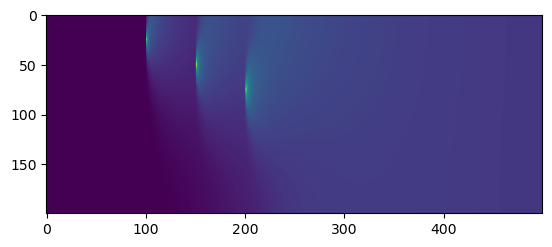

In [85]:
plt.imshow(voltage_monitor.v /volt);

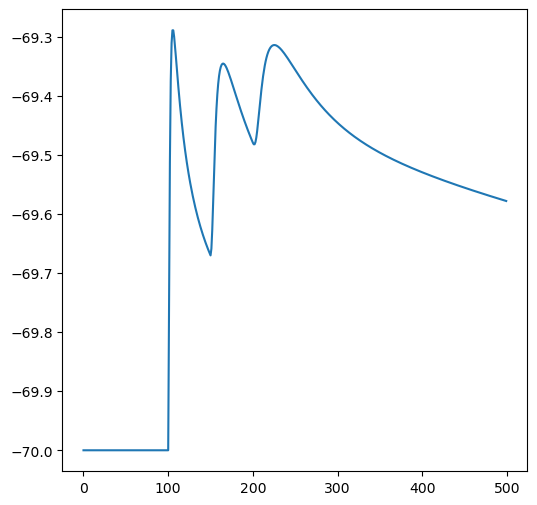

In [91]:
fig,ax = plt.subplots(figsize=(6,6))

ax.plot(voltage_monitor.v[0, :]/mV);

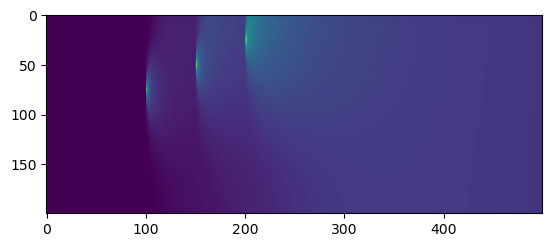

In [92]:
t_spikes = [1000, 1500, 2000]
l_spikes = [300. * um, 200. * um, 100. * um]
current = get_spikes_current(t_spikes, 5000, us, 0.8*namp)

voltage_monitor, cable_model = passive_cable(
    I_arr = current,
    I_loc = l_spikes,
    params = ps2,
    duration = 5 * ms,
    initial_voltage = ps2["E_LEAK"], 
    nr_compartments=200        
)

plt.imshow(voltage_monitor.v /volt);

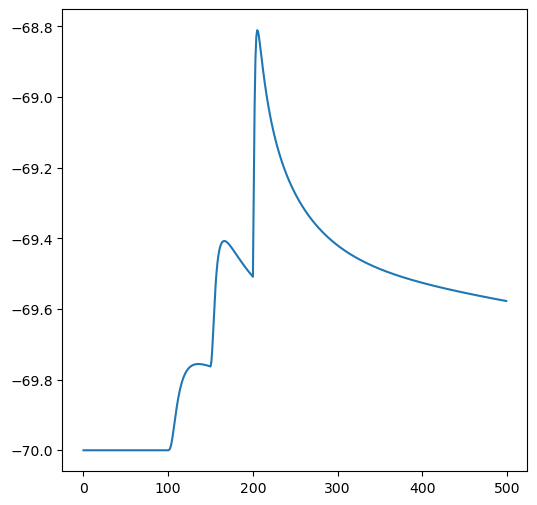

In [93]:
fig,ax = plt.subplots(figsize=(6,6))

ax.plot(voltage_monitor.v[0, :]/mV);

# 4.3. Exercise: Effect of cable parameters

In [104]:
ps3 = ps1.copy()
ps4 = ps1.copy()

In [105]:
defaultclock.dt = 0.005 * ms 

In [106]:
ps3["R_TRANSVERSAL"] = 1.25 * Mohm * mm ** 2
ps3["CAPACITANCE"] = 0.8 * uF / cm ** 2

ps4["R_TRANSVERSAL"] = 5.0 * Mohm * mm ** 2
ps4["CAPACITANCE"] = 0.2 * uF / cm ** 2


In [107]:
t_spikes = [50]
l_spikes = [400. * um]
current = get_spikes_current(t_spikes, 200, us, 0.8*namp)

voltage_monitor, cable_model = passive_cable(
    I_arr = current,
    I_loc = l_spikes,
    params = ps3,
    duration = 0.2 * ms,
    initial_voltage = ps3["E_LEAK"], 
    nr_compartments=200        
)

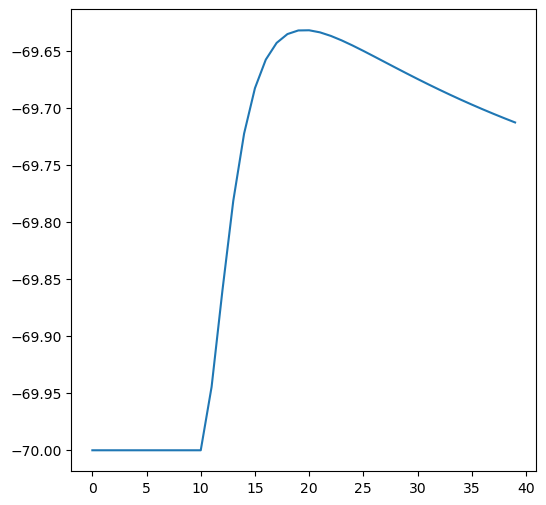

In [108]:
fig,ax = plt.subplots(figsize=(6,6))

ax.plot(voltage_monitor.v[-1, :]/mV);

In [109]:
t_spikes = [50]
l_spikes = [400. * um]
current = get_spikes_current(t_spikes, 200, us, 0.8*namp)

voltage_monitor, cable_model = passive_cable(
    I_arr = current,
    I_loc = l_spikes,
    params = ps4,
    duration = 0.2 * ms,
    initial_voltage = ps4["E_LEAK"], 
    nr_compartments=200        
)

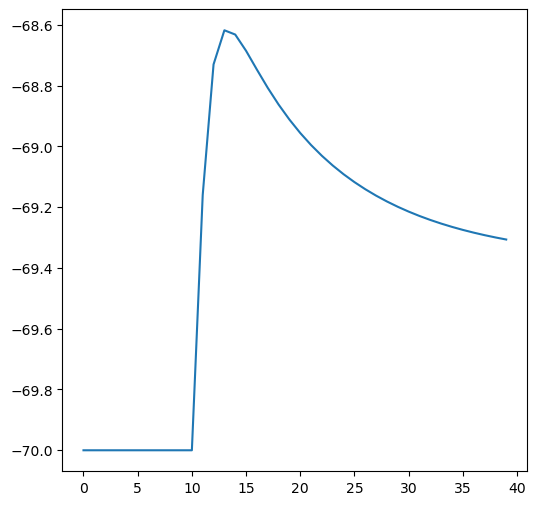

In [110]:
fig,ax = plt.subplots(figsize=(6,6))

ax.plot(voltage_monitor.v[-1, :]/mV);

# 4.4. Exercise: stationary solution and comparison with theoretical result